In [2]:
import warnings

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pprint
pp = pprint.PrettyPrinter(indent=4)

pd.set_option("display.precision", 2)
warnings.filterwarnings("ignore")

# some imports to set up plotting
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
# !pip install seaborn
import seaborn as sns

# import some nice vis settings
sns.set()
# Graphics in the Retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8



In [3]:
DATA_URL = "./data/"
df = pd.read_csv(DATA_URL + "cardiovascular.csv", sep=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.shape

(70000, 13)

Convert the data into long format

In [5]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)

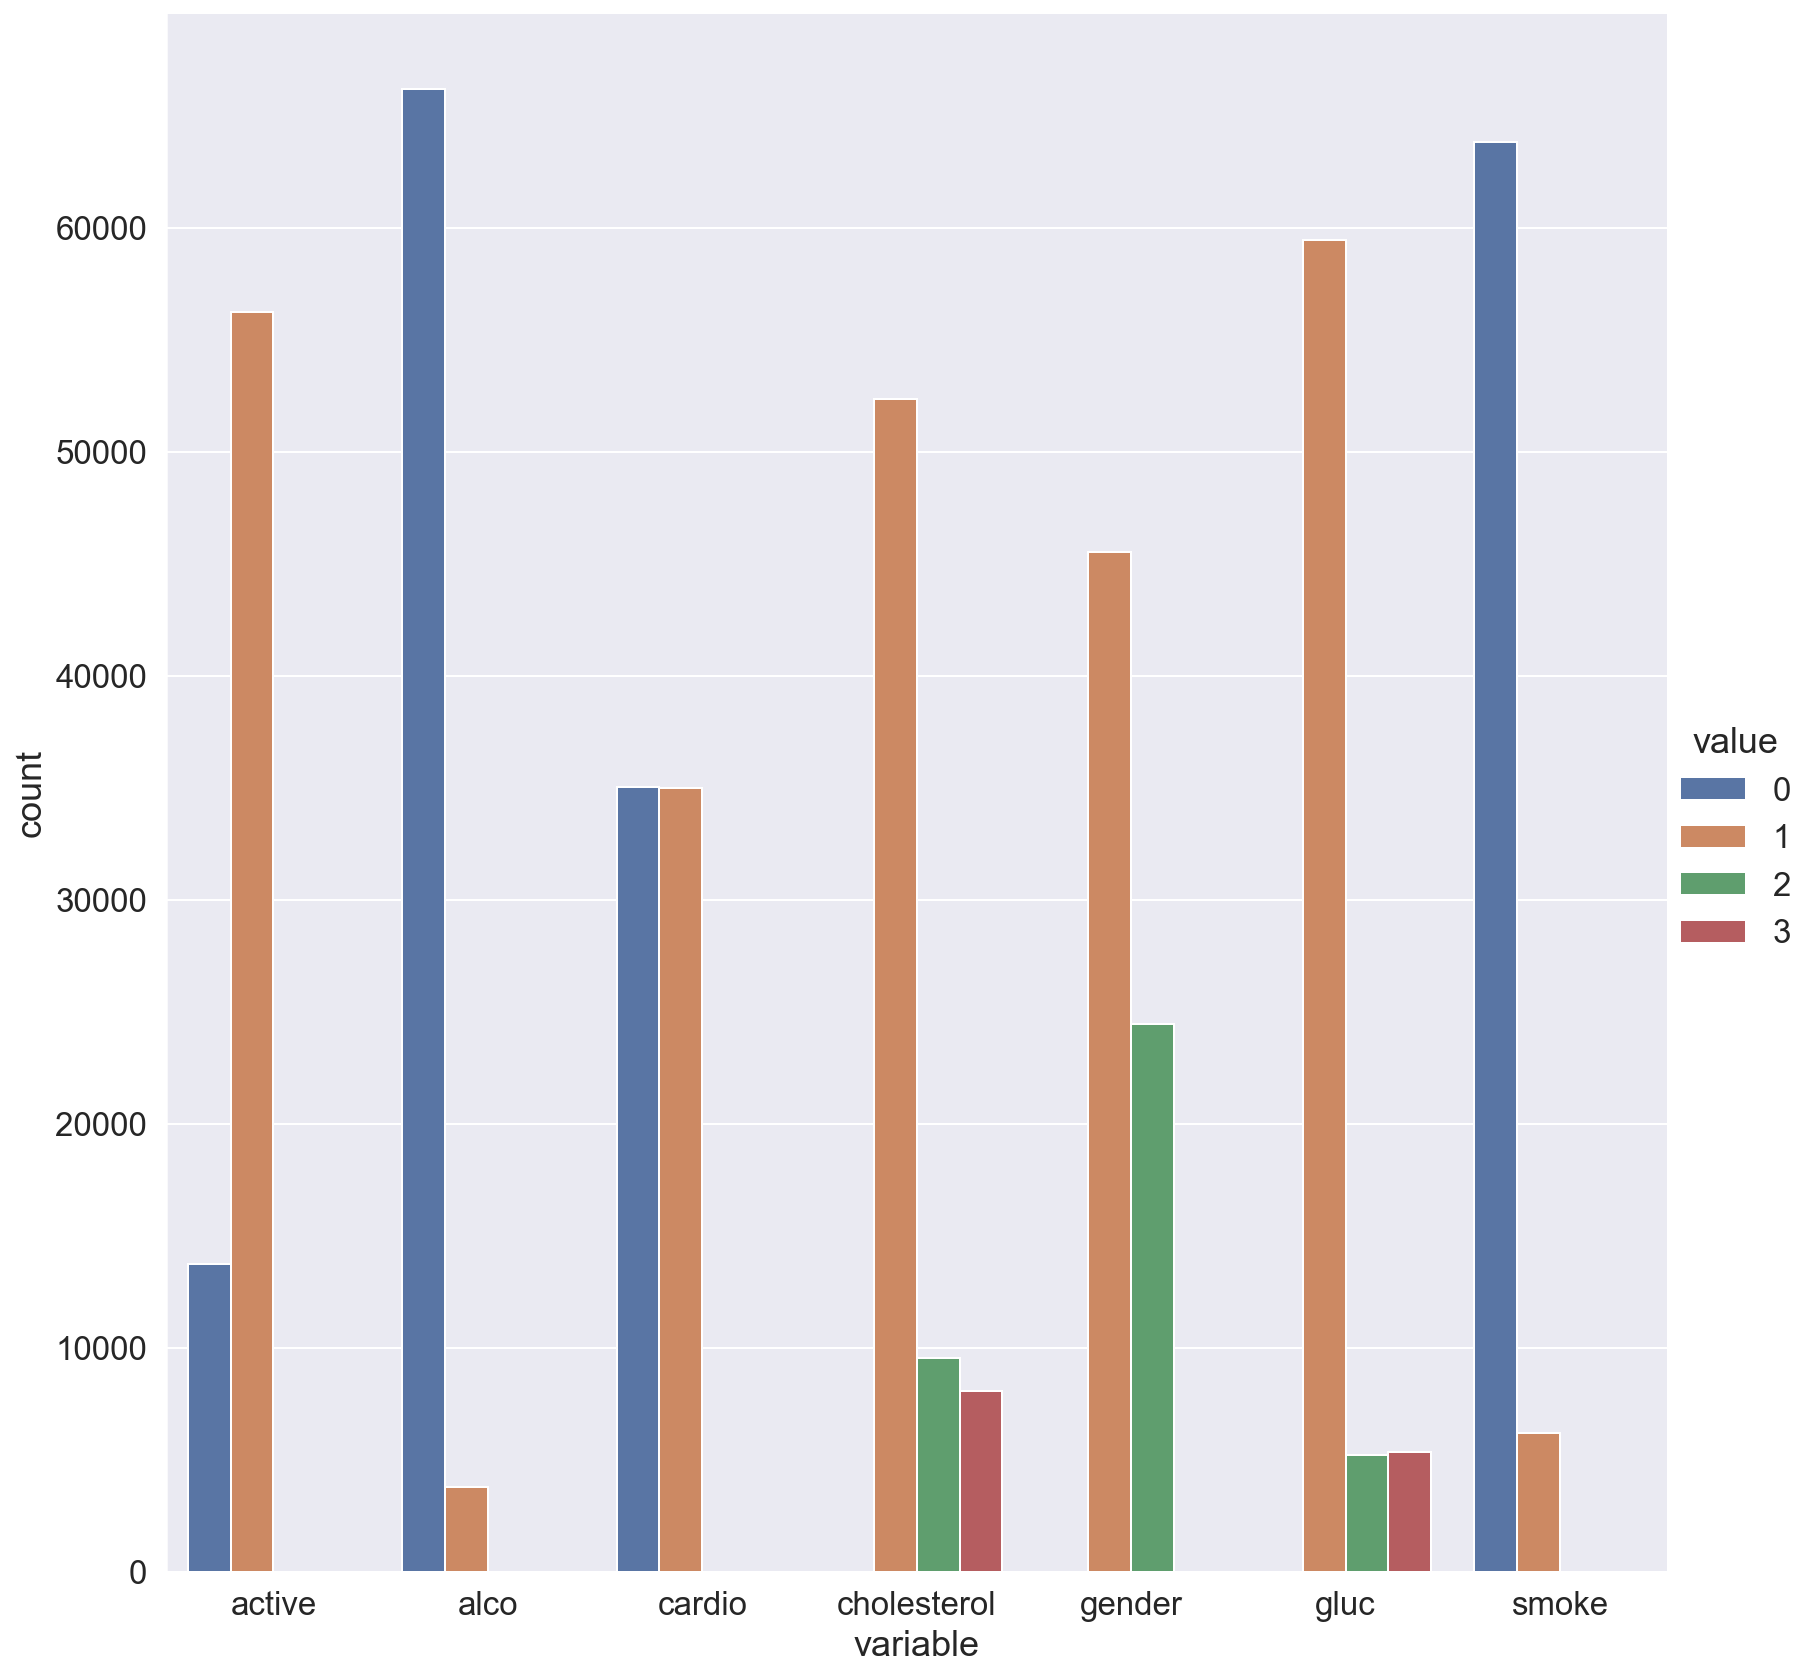

In [6]:
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.factorplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar", size=12
);

 The target classes are balanced. 

 Split the dataset by target values

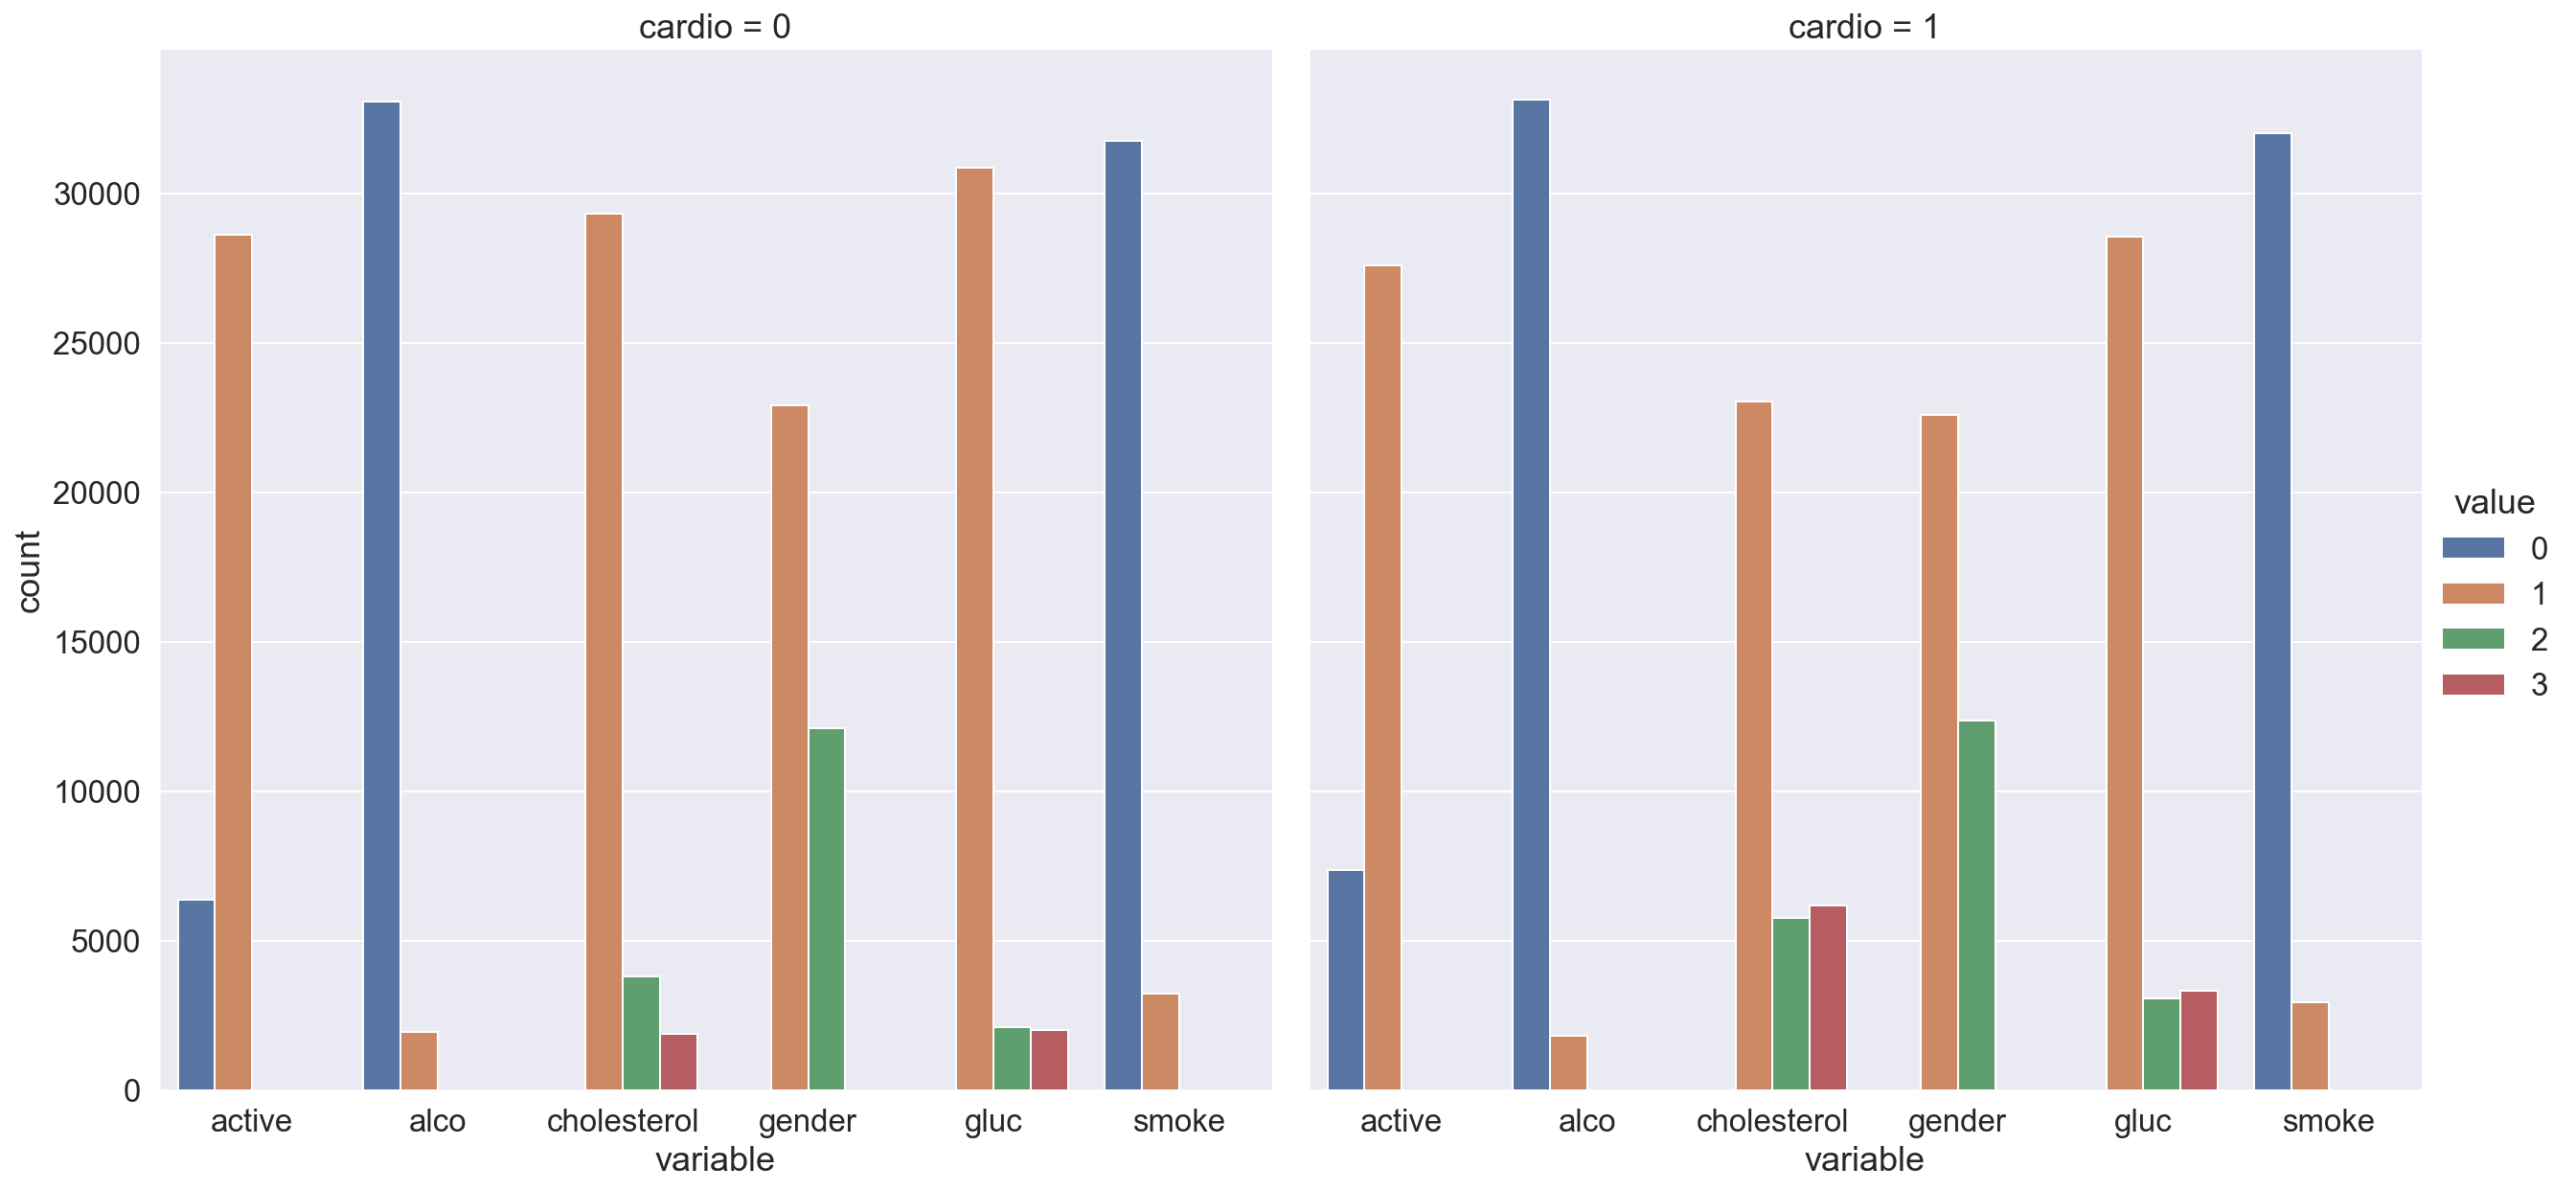

In [7]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.factorplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
    size=9,
);

 Distribution of cholesterol and glucose levels great differs by the value of the target variable

In [8]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


* 5 numerical features (excluding id);
* 7 categorical features;
* 70000 records in total.

How many men and women are present in this dataset? Values of the gender feature were not given (whether “1” stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.

In [9]:
df["gender"].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

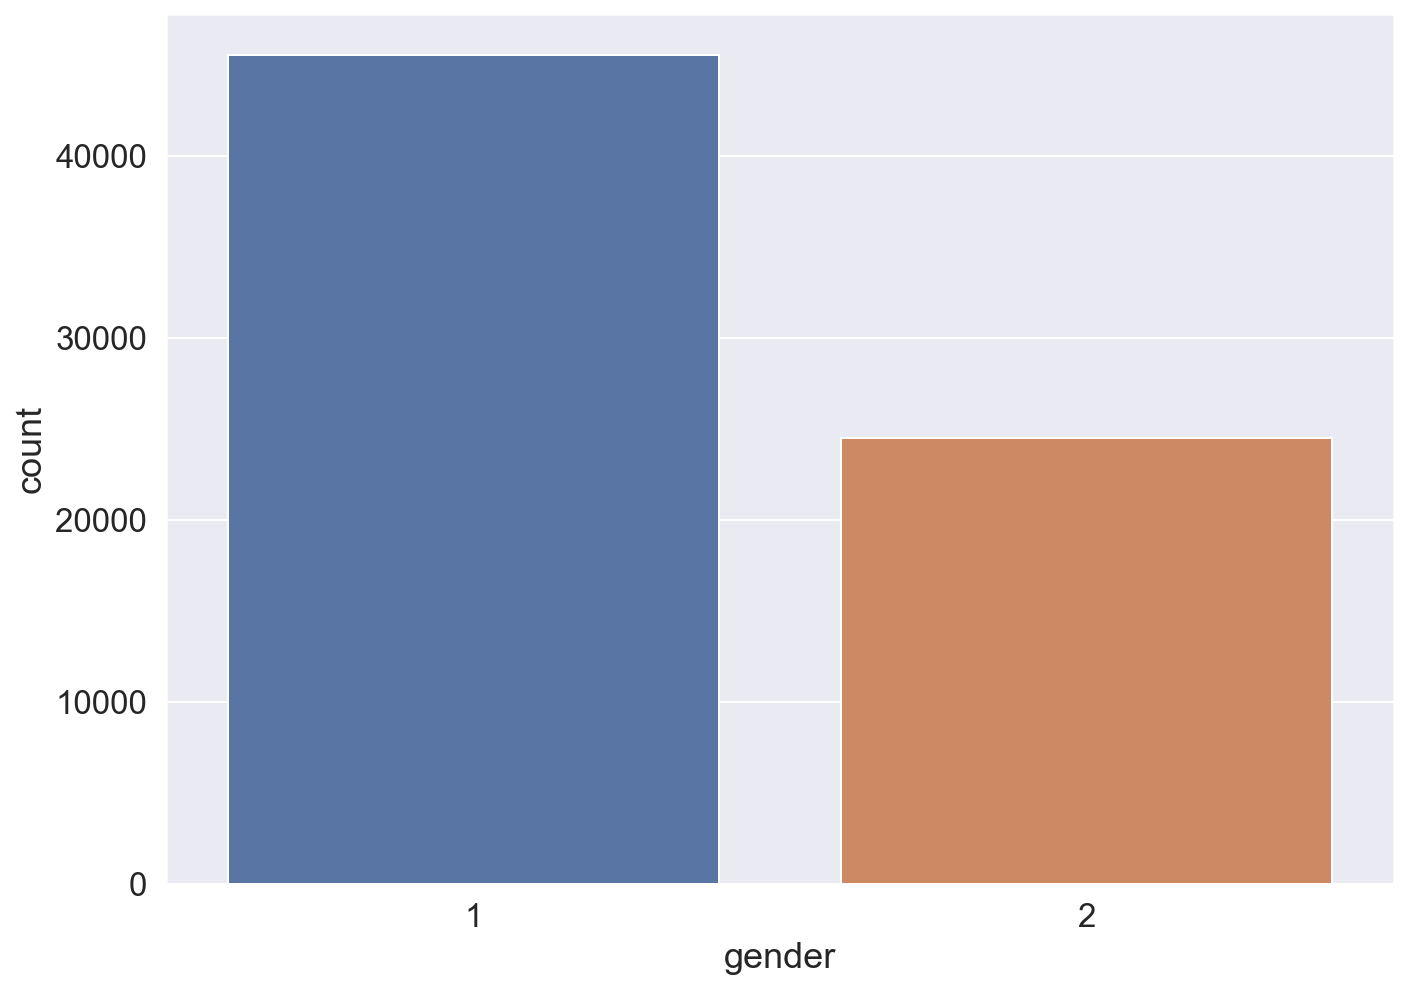

In [10]:
sns.countplot(x="gender", data=df)

In [13]:
df.groupby(["gender"])["height"].agg([np.mean, np.count_nonzero])

,mean,count_nonzero
gender,,
1,161.36,45530
2,169.95,24470


* gender=1 represents females, and gender=2 – males
* Sample contains 45530 women and 24470 men

Who more often report consuming alcohol – men or women?

In [16]:
pd.crosstab(df["gender"], df["alco"])

alco,0,1
gender,,
1,44369,1161
2,21867,2603


In [17]:
df.groupby("gender")["alco"].mean()

gender
1    0.03
2    0.11
Name: alco, dtype: float64

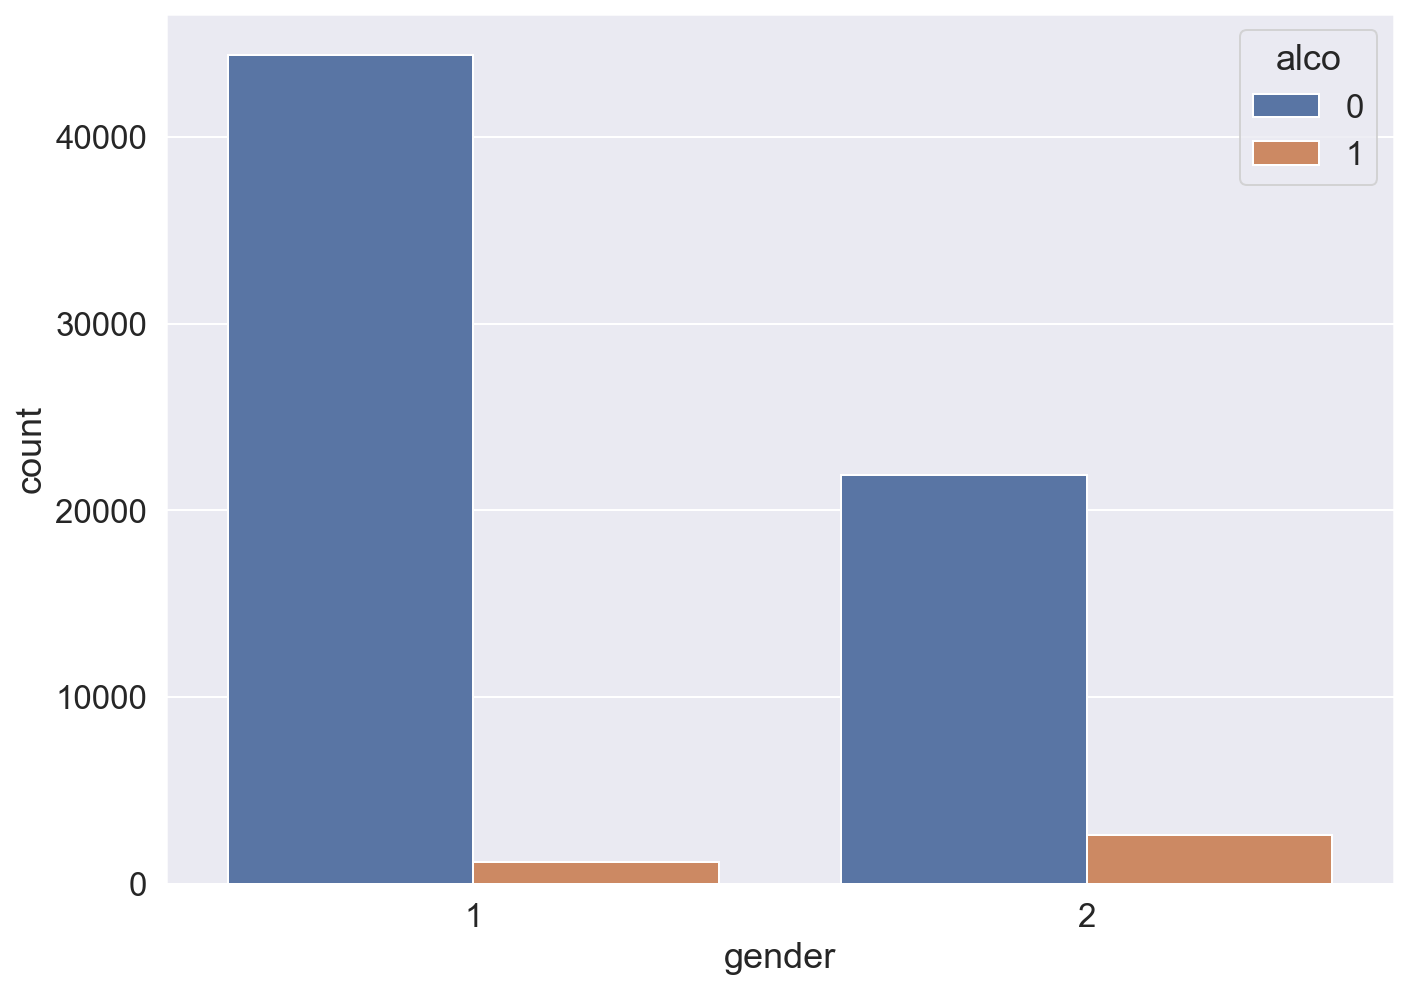

In [14]:
sns.countplot(x="gender", 
                hue="alco", 
                data=df);

Obvious: Men consume more alcohol!

What’s the rounded difference between the percentages of smokers among men and women?

In [19]:
df.groupby(["gender"])['smoke'].value_counts(normalize=True)

gender  smoke
1       0        0.98
        1        0.02
2       0        0.78
        1        0.22
Name: smoke, dtype: float64

20% - rounded difference between the percentages

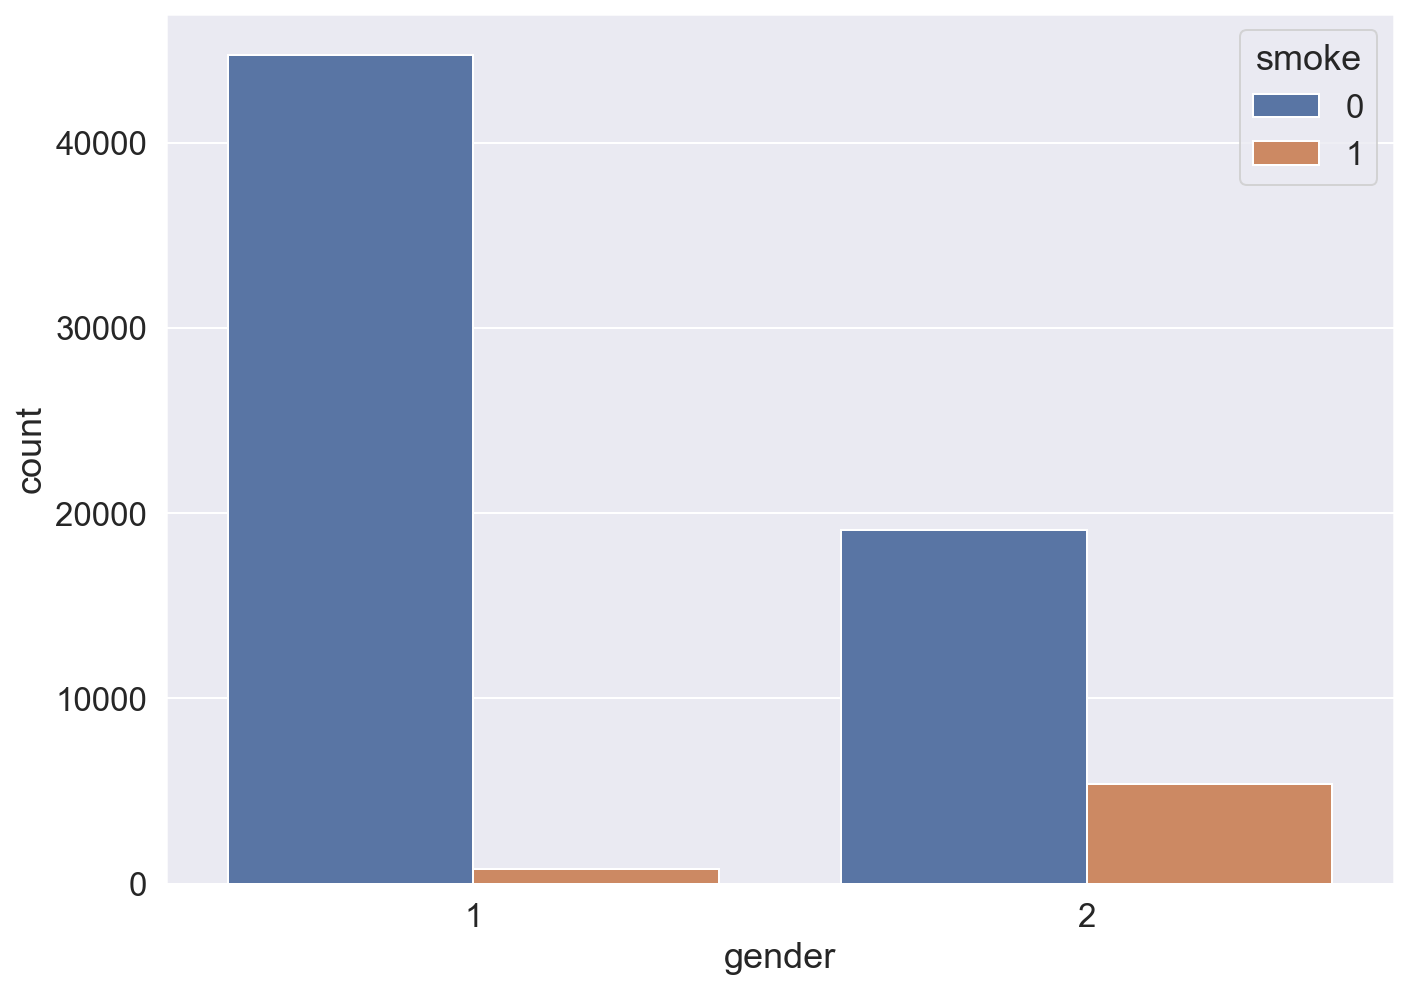

In [18]:
sns.countplot(x="gender", 
                hue="smoke", 
                data=df);

What’s the rounded difference between median values of age (in months) for non-smokers and smokers? You’ll need to figure out the units of feature age in this dataset.

In [22]:
df.groupby(["smoke"])["age"].median() / 31

smoke
0    636.19
1    616.94
Name: age, dtype: float64

Answer is 20 months

Smoking men aged from 60 to 65 — for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180)

How to verify that using our data?

* Calculate age_years feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.

In [26]:
# df["age_years"] = df["age"] / 365.25
df["age_years"] = (df["age"] / 365.25).round().astype("int")
df["age_years"].head(10)

0    50
1    55
2    52
3    48
4    48
5    60
6    61
7    62
8    48
9    54
Name: age_years, dtype: int64

In [59]:
df["age_years"].max()

65

In [60]:
smoking_old_men = df[
    (df["gender"] == 2)
    & (df["age_years"] >= 60)
    & (df["age_years"] < 65)
    & (df["smoke"] == 1)
]

If cholesterol level in this age group is 1, and systolic pressure is below 120, then the proportion of people with CVD:

In [61]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 1) & (smoking_old_men["ap_hi"] < 120)
]["cardio"].mean()

0.2631578947368421

26%

If, however, cholesterol level in this age group is 3, and systolic pressure is from 160 to 180, then the proportion of people with a CVD:

In [62]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 3)
    & (smoking_old_men["ap_hi"] >= 160)
    & (smoking_old_men["ap_hi"] < 180)
]["cardio"].mean()

0.8636363636363636

86%

Calculate fractions of ill people (with CVD) in the two groups of people described in the task. What’s the ratio of these two fractions?

In [63]:
0.86/0.26

3.3076923076923075